In [2]:
%load_ext autoreload
%autoreload 2
import sys
import os
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import denmatsim.simseq as sim
from matplotlib import pyplot as plt
import numpy as np
import json

In [3]:
# Create a couple of spin systems from the references for MARSS
# Actually load them from fid-A and see if I can just modify them
import scipy.io
fidASpinSysFile = '/Users/wclarke/Documents/MATLAB/FID-A/simulationTools/metabolites/spinSystems.mat'
# fidASpinSys = scipy.io.loadmat(fidASpinSysFile)

fidASys = {}
import h5py
with h5py.File(fidASpinSysFile, 'r') as f:
#     print(f.keys())
    for k in f:
        if 'sys' in k:
            name = k[3:]
            tmpJ = np.array(f[k]['J']).T
            tmpCS = np.array(f[k]['shifts'][0])
            tmpScale = np.array(f[k]['scaleFactor'][0])
            tmpDict = {'shifts':tmpCS,'j':tmpJ,'scale':tmpScale}
            fidASys.update({name:tmpDict})
print(fidASys['Tau'])

{'shifts': array([3.4206, 3.4206, 3.2459, 3.2459]), 'j': array([[0.   , 0.   , 6.742, 6.464],
       [0.   , 0.   , 6.403, 6.792],
       [0.   , 0.   , 0.   , 0.   ],
       [0.   , 0.   , 0.   , 0.   ]]), 'scale': array([1.])}


{'shifts': array([3.7433, 2.0375, 2.12  , 2.3378, 2.352 ]), 'j': array([[  0.   ,   7.331,   4.651,   0.   ,   0.   ],
       [  0.   ,   0.   , -14.849,   6.413,   8.406],
       [  0.   ,   0.   ,   0.   ,   8.478,   6.875],
       [  0.   ,   0.   ,   0.   ,   0.   , -15.915],
       [  0.   ,   0.   ,   0.   ,   0.   ,   0.   ]]), 'scale': array([1.])}
Simulation running using mode 1d. Axis order = [0 1 2].


<IPython.core.display.Javascript object>


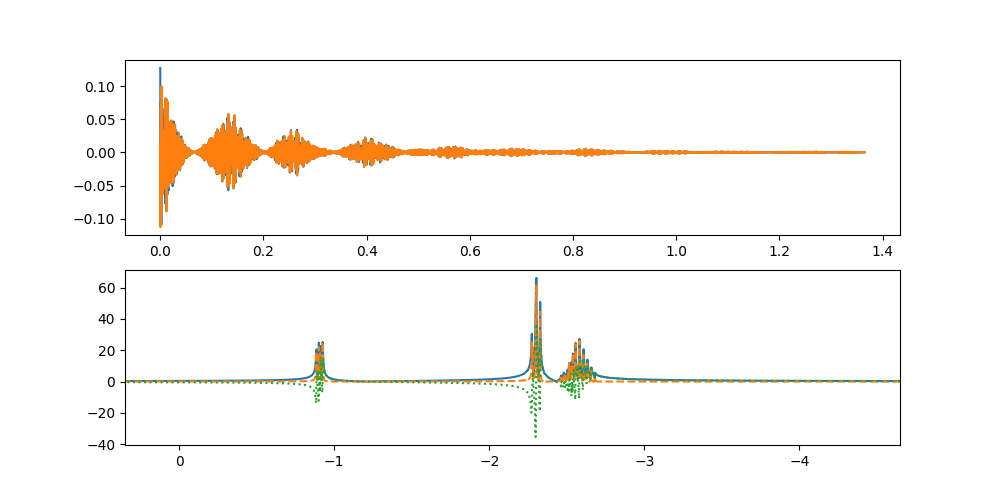

(0.34999999999999964, -4.65)

In [30]:
from copy import deepcopy
# Read json sequence file
jsonFile = '../example.json'

with open(jsonFile,'r') as jsonFile:
    jsonString = jsonFile.read()
    params = json.loads(jsonString)
    
description = params['description']# For use writing file        

# Define a spin system - 3 peaks, 2 coupled.
# spinsys = {'shifts':np.array([0,2, -1],dtype=float),'j':np.array([[0,0,10],[0,0,0],[10,0,0]])}
# spinsys = deepcopy(fidASys['Tau'])
spinsys = deepcopy(fidASys['Glu'])
print(spinsys)

# Quick update of a couple of parameters to match the MARSS sim
params['Rx_SW'] = 12000
params['Rx_Points'] = 16384
params['Rx_LW'] = 1
params['centralShift'] = 4.65
params['resolution'] = [40,40,40]

# Shift pulse central frequency to 2.7 ppm (1.95 ppm below water)
params['RF'][0]['frequencyOffset'] = -1.95*params['B0']*42.5574
params['RF'][1]['frequencyOffset'] = -1.95*params['B0']*42.5574
params['RF'][2]['frequencyOffset'] = -1.95*params['B0']*42.5574

params['Rx_Phase'] = 2.3

# Run the simulation
FID,ax,_ = sim.simseq(spinsys,params)

# Plot the results
fig, (ax1, ax2)= plt.subplots(2,1,figsize=(10, 5))
ax1.plot(ax['time'],np.real(FID))
ax1.plot(ax['time'],np.imag(FID))
spec = np.fft.fftshift(np.fft.fft(FID))

ax2.plot(ax['ppm'],np.abs(spec))
ax2.plot(ax['ppm'],np.real(spec),'--')
ax2.plot(ax['ppm'],np.imag(spec),':')
ax2.set_xlim([5-4.65,0-4.65])

In [24]:
# Read in the MARSS results
import scipy.io
import os
resultsDir = '/Users/wclarke/Documents/MATLAB/SpectroscopySimulation/basisGeneration/simulationResults/uzay_steam_gui_7T/SummedSpins_for_MARSSinput'
marssResults = {}
for file in os.listdir(resultsDir):
    filename = os.fsdecode(file)
    if filename.endswith(".mat"):
        currentFile = os.path.join(resultsDir,filename)
        tmp = scipy.io.loadmat(currentFile)
        marssResults.update({filename.split('.')[0]:np.squeeze(np.array(tmp['exptDat'][0][0][3]))})

print(marssResults.keys())
print(marssResults['Tau'].shape)
print(marssResults['Tau'])

dict_keys(['Tau', 'Gln', 'Gly', 'PCh', 'Lac', 'NAA', 'GPC', 'GSH', 'Asc', 'GABA', 'mI', 'NAAG', 'Asp', 'Cr', 'Ala', 'PCr', 'Glc', 'sI', 'PE', 'Glu'])
(16384,)
[ 1.07772366e+01+0.28216406j  1.06017611e+01-1.92164344j
  9.97880455e+00-4.04126109j ...  7.23698588e-03-0.03702156j
 -4.62516497e-04-0.03730704j -7.97268701e-03-0.03601823j]


<IPython.core.display.Javascript object>


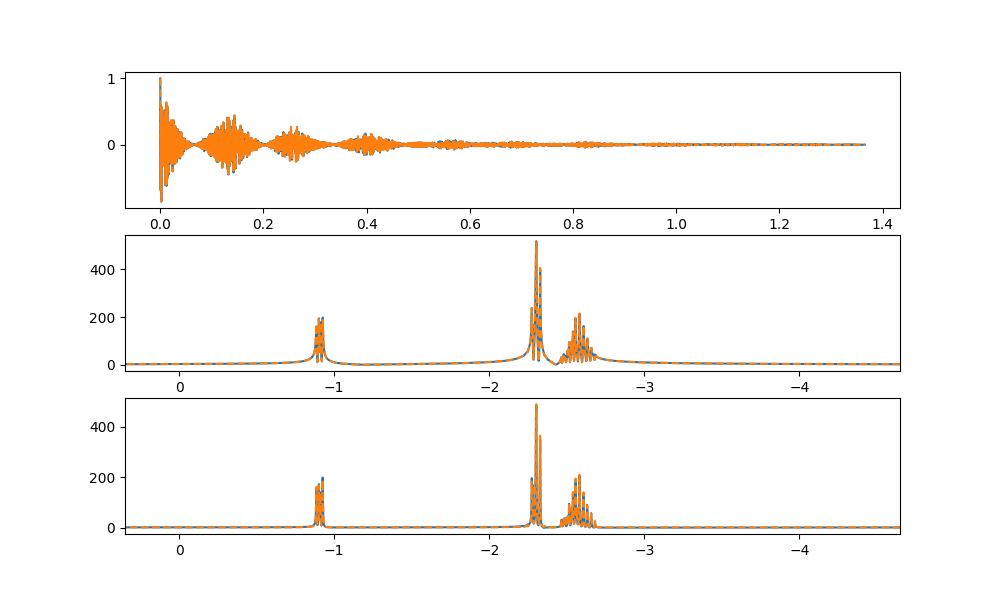

(0.34999999999999964, -4.65)

In [31]:
%matplotlib nbagg

marssFID = marssResults['Glu']
marssFID /= np.max(np.abs(marssFID))
marssSpec = np.fft.fftshift(np.fft.fft(marssFID))

FID /= np.max(np.abs(FID))

spec = np.fft.fftshift(np.fft.fft(FID))

fig, (ax1, ax2,ax3)= plt.subplots(3,1,figsize=(10, 6))
ax1.plot(ax['time'],np.real(FID))
ax1.plot(ax['time'],np.real(marssFID),'--')

ax2.plot(ax['ppm'],np.abs(spec))
ax2.plot(ax['ppm'],np.abs(marssSpec),'--')
ax2.set_xlim([5-4.65,0-4.65])

ax3.plot(ax['ppm'],np.real(spec))
ax3.plot(ax['ppm'],np.real(marssSpec),'--')
ax3.set_xlim([5-4.65,0-4.65])